<a href="https://colab.research.google.com/github/hyacob-89/fake_news_detector/blob/master/fake_news_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <u>__Dependencies__<u/>

In [3]:
# Basic libraries
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Natural Language Processing
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [0]:
# Importing the dataset
fake_df = pd.read_csv("/fake_cleaned.csv")
fake_df.head()

In [0]:
# Importing the dataset
true_df = pd.read_csv("/true_cleaned.csv")
true_df.head()

**Tokenization**
(these couple rows of df2 will not be saved in cvs file)

In [20]:
df2 = pd.concat([fake_df[['articletext','articlesubject', 'label']], true_df[['articletext','articlesubject', 'label']]], axis=0)

#Reset the index
# df1 = df1.set_index(inplace=True)

# r
print("Shape:", df2.shape)
df2.head()

Shape: (8002, 3)


,articletext,articlesubject,label
5376,former beatle george harrison s estate is livi...,News,1
1227,as former fbi director james comey gave his te...,News,1
3269,americans have been spending well over trilli...,"2016@realDonaldTrump to himself: """"You're res...",1
13910,in typical obama fashion the extravagant tax p...,politics,1
12675,obama is a scoundrel he ll say anything to sta...,politics,1


In [21]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
#Function to remove Punctuation
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])# It will discard all punctuations
    return text_nopunct

df2['body_text_clean'] = df2['articletext'].apply(lambda x: remove_punct(x))

df2.head()

,articletext,articlesubject,label,body_text_clean
5376,former beatle george harrison s estate is livi...,News,1,former beatle george harrison s estate is livi...
1227,as former fbi director james comey gave his te...,News,1,as former fbi director james comey gave his te...
3269,americans have been spending well over trilli...,"2016@realDonaldTrump to himself: """"You're res...",1,americans have been spending well over trilli...
13910,in typical obama fashion the extravagant tax p...,politics,1,in typical obama fashion the extravagant tax p...
12675,obama is a scoundrel he ll say anything to sta...,politics,1,obama is a scoundrel he ll say anything to sta...


In [23]:
import re
# Function to Tokenize words
def tokenize(text):
    tokens = re.split('\W+', text) #W+ means that either a word character (A-Za-z0-9_) or a dash (-) can go there.
    return tokens

df2['body_text_tokenized'] = df2['body_text_clean'].apply(lambda x: tokenize(x.lower())) 
#We convert to lower as Python is case-sensitive. 

df2.head()

,articletext,articlesubject,label,body_text_clean,body_text_tokenized
5376,former beatle george harrison s estate is livi...,News,1,former beatle george harrison s estate is livi...,"[former, beatle, george, harrison, s, estate, ..."
1227,as former fbi director james comey gave his te...,News,1,as former fbi director james comey gave his te...,"[as, former, fbi, director, james, comey, gave..."
3269,americans have been spending well over trilli...,"2016@realDonaldTrump to himself: """"You're res...",1,americans have been spending well over trilli...,"[, americans, have, been, spending, well, over..."
13910,in typical obama fashion the extravagant tax p...,politics,1,in typical obama fashion the extravagant tax p...,"[in, typical, obama, fashion, the, extravagant..."
12675,obama is a scoundrel he ll say anything to sta...,politics,1,obama is a scoundrel he ll say anything to sta...,"[obama, is, a, scoundrel, he, ll, say, anythin..."


In [0]:
#Modeling

In [40]:
df1 = pd.concat([fake_df[['articletext','articlesubject', 'label']], true_df[['articletext','articlesubject', 'label']]], axis=0)

#Reset the index
# df1 = df1.set_index(inplace=True)

# r
print("Shape:", df1.shape)
df1.head()
# df1.drop(df1.index[[2]], inplace=True)
# df1.head()

Shape: (8002, 3)


,articletext,articlesubject,label
0,former beatle george harrison s estate is livi...,News,1
1,as former fbi director james comey gave his te...,News,1
3,in typical obama fashion the extravagant tax p...,politics,1
4,obama is a scoundrel he ll say anything to sta...,politics,1
5,one of the gop s biggest donors who used to be...,News,1


## <u>__Data Analysis__<u/>

In [0]:
# define function for graphs
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

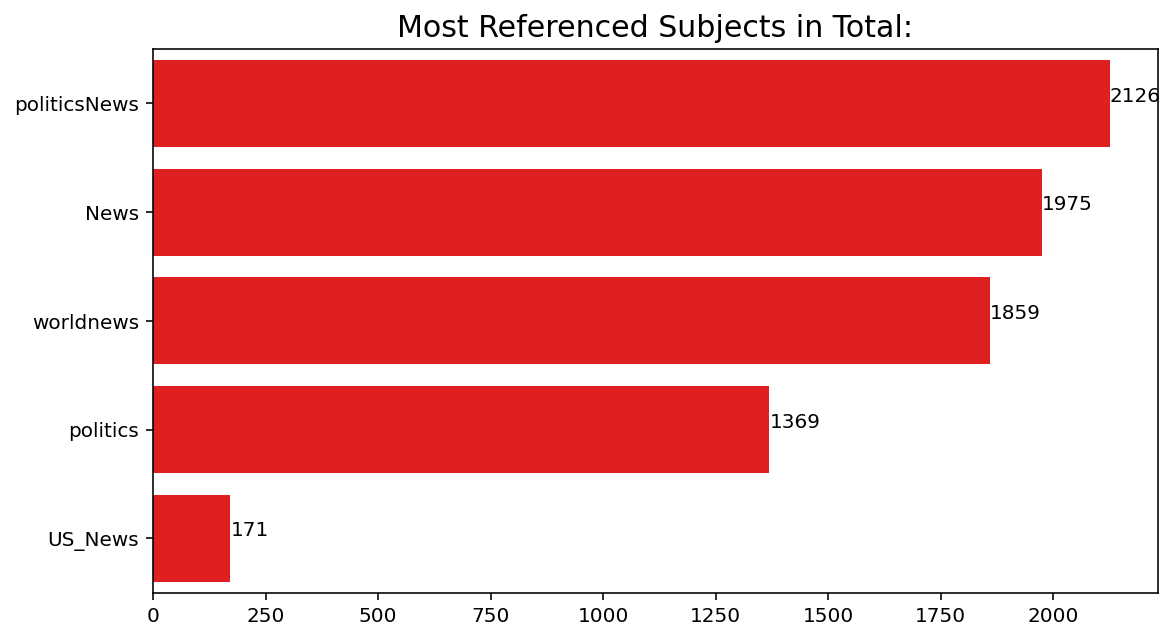

In [42]:
# Set x values: # of posts for both datasets
df_domain = df1['articlesubject'].value_counts() 
df_domain = df_domain.sort_values(ascending=False).head(5)

# Set y values: Domains 
df_domain_index = list(df_domain.index)

# Call function
bar_plot(df_domain.values, df_domain_index, 'Most Referenced Subjects in Total:' ,'r')

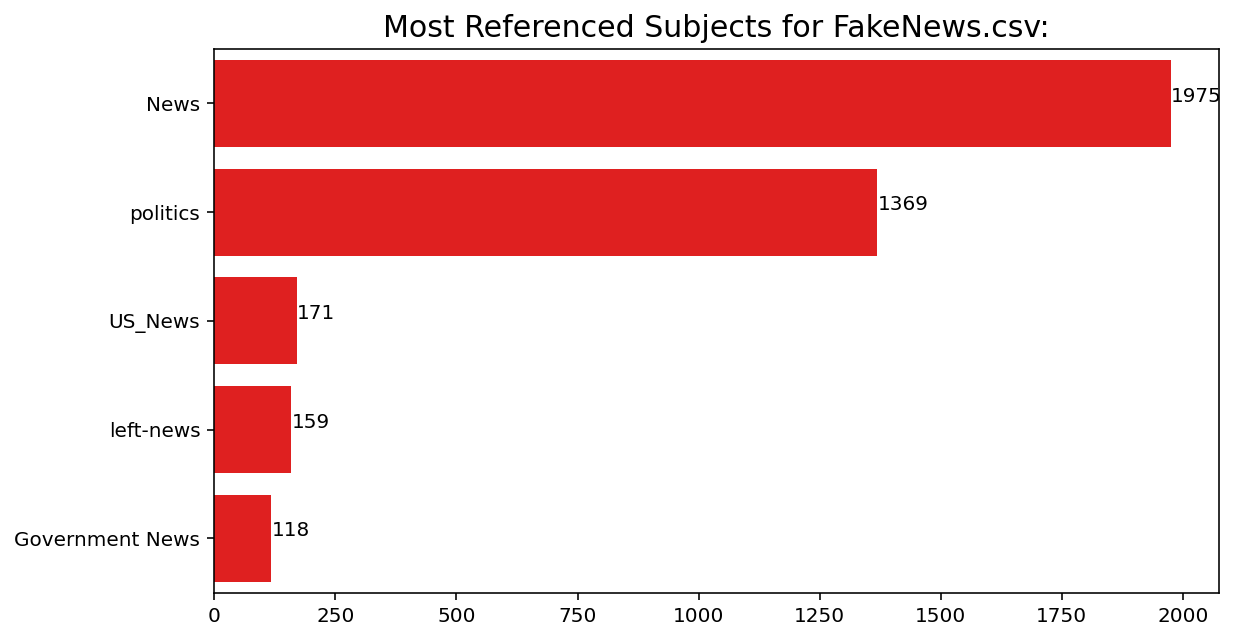

In [43]:
# Set x values: # of posts fake df
df_domain = fake_df['articlesubject'].value_counts() 
df_domain = df_domain.sort_values(ascending=False).head(5)

# Set y values: Domains 
df_domain_index = list(df_domain.index)

# Call function
bar_plot(df_domain.values, df_domain_index, 'Most Referenced Subjects for FakeNews.csv:' ,'r')

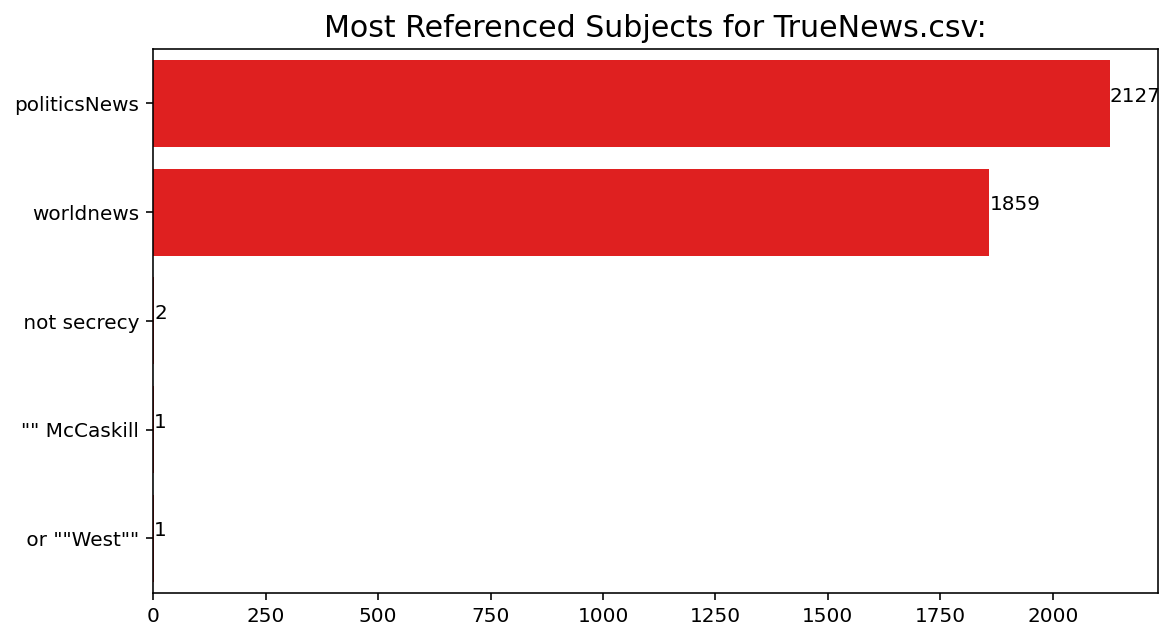

In [44]:
# Set x values: # of posts for true df
df_domain = true_df['articlesubject'].value_counts() 
df_domain = df_domain.sort_values(ascending=False).head(5)

# Set y values: Domains 
df_domain_index = list(df_domain.index)

# Call function
bar_plot(df_domain.values, df_domain_index, 'Most Referenced Subjects for TrueNews.csv:' ,'r')

*Natural Language Processing (NLP)*

**- Apply CountVectorizer()**

*   Count Vectorize df1 where 'label' is 1
*   ngram_range = (1,1)



In [45]:
# Set variables to show Fake Titles
mask_on = df1['label'] == 1
df_onion_titles = df1[mask_on]['articletext']

# Instantiate a CountVectorizer
cv1 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
onion_cvec = cv1.fit_transform(df_onion_titles)

# Convert onion_cvec into a DataFrame
onion_cvec_df = pd.DataFrame(onion_cvec.toarray(),
                   columns=cv1.get_feature_names())

# Inspect head of fake Titles cvec
print(onion_cvec_df.shape)

(4000, 38570)



-**Apply CountVectorizer()**
   *   Vectorize df where 'label' is 0
   *   ngram_range = (1,1)



In [46]:
mask_no = df1['label'] == 0
df_not_onion_titles = df1[mask_no]['articletext']

# Instantiate a CountVectorizer
cv2 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
not_onion_cvec = cv2.fit_transform(df_not_onion_titles)

# Convert onion_cvec into a DataFrame
not_onion_cvec_df = pd.DataFrame(not_onion_cvec.toarray(),
                   columns=cv2.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(not_onion_cvec_df.shape)

(4000, 32054)


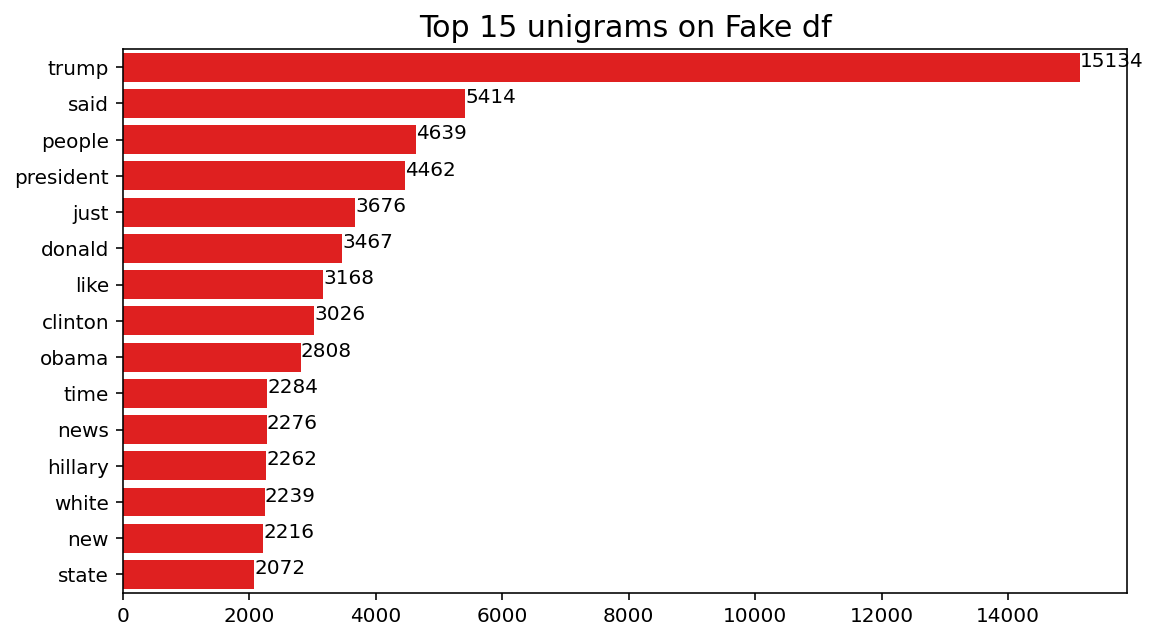

In [47]:
# Set up variables to contain top 15 most used words in Fake df
onion_wc = onion_cvec_df.sum(axis = 0)
onion_top_5 = onion_wc.sort_values(ascending=False).head(15)

# Call function
bar_plot(onion_top_5.values, onion_top_5.index, 'Top 15 unigrams on Fake df','r')

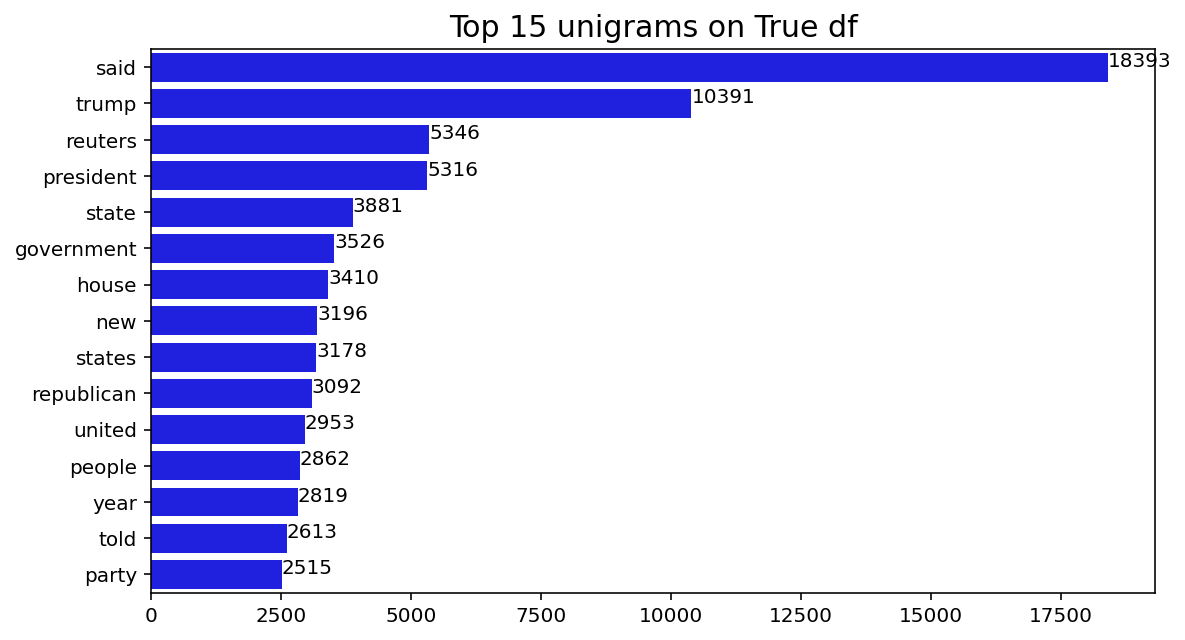

In [48]:
# Set up variables to contain top 15 most used words in Onion
nonion_wc = not_onion_cvec_df.sum(axis = 0)
nonion_top_5 = nonion_wc.sort_values(ascending=False).head(15)

# Call function
bar_plot(nonion_top_5.values, nonion_top_5.index, 'Top 15 unigrams on True df','b')

In [49]:
# Create list of unique words in top five
not_onion_5_set = set(nonion_top_5.index)
onion_5_set = set(onion_top_5.index)

# Return common words
common_unigrams = onion_5_set.intersection(not_onion_5_set)
common_unigrams

{'new', 'people', 'president', 'said', 'state', 'trump'}

**-Apply CountVectorize** 
*   Count Vectorize df where "label" is 1
*   ngram_range = (2,2)




In [2]:
# Set variables to show Fake Titles
mask = df1['label'] == 1
df_onion_titles = df1[mask]['articletext']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
onion_cvec = cv.fit_transform(df_onion_titles)

# Convert onion_cvec into a DataFrame
onion_cvec_df = pd.DataFrame(onion_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of Fake Titles cvec
print(onion_cvec_df.shape)

NameError: ignored

***- Apply CountVectorize ***
  *   Count Vectorize df where subreddit is 0
  *   ngram_range = (2,2) 

```
# This is formatted as code
```





In [1]:
# Set variables to show True Titles
mask = df1['label'] == 0
df_not_onion_titles = df1[mask]['articletext']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
not_onion_cvec = cv.fit_transform(df_not_onion_titles)

# Convert onion_cvec into a DataFrame
not_onion_cvec_df = pd.DataFrame(not_onion_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of  True Titles cvec
print(not_onion_cvec_df.shape)

NameError: ignored

In [0]:
# Set up variables to contain top  most used bigrams in Fake df
onion_wc = onion_cvec_df.sum(axis = 0)
onion_top_5 = onion_wc.sort_values(ascending=False).head(35)

# Call function
bar_plot(onion_top_5.values, onion_top_5.index, 'Top bigrams on Fake df','r')

In [0]:
# Set up variables to contain top  most used bigrams in r/nottheonion
nonion_wc = not_onion_cvec_df.sum(axis = 0)
nonion_top_5 = nonion_wc.sort_values(ascending=False).head(35)

# Call function
bar_plot(nonion_top_5.values, nonion_top_5.index, 'Top bigrams on True df','b')

In [0]:
not_onion_5_list = set(nonion_top_5.index)
onion_5_list = set(onion_top_5.index)

# Return common words
common_bigrams = onion_5_list.intersection(not_onion_5_list)
common_bigrams

Take out {'barack obama','donald trump','hillary clinton','new york','secretary state','supreme court','trump administration','trump said','united states','white house','year old'} from dataset when modeling, since these words occur frequently in both subreddits.

Create custom stop_words to include common frequent words
Referencing the common most-used words, add them to a customized stop_words list.

# **Modeling**

In [0]:
from sklearn.feature_extraction import stop_words
# Create lists 
custom = stop_words.ENGLISH_STOP_WORDS
custom = list(custom)
common_unigrams = list(common_unigrams)
common_bigrams = list(common_bigrams)

# Append unigrams to list 
for i in common_unigrams:
    custom.append(i)

    
# Append bigrams to list 
for i in common_bigrams:
    split_words = i.split(" ")
    for word in split_words:
        custom.append(word)

####Here I conduct model-prep and use Pipeline and 

1.   List item
2.   List item

GridSearch to determine the most optimal model to run my data on.


In [0]:
#Baseline Score
df1['label'].value_counts(normalize=True)

####'I expect my model to be better than 54%. The majority class is 0, or, True. If the model is not better than 54%, I know the model is not performing well.'


In [0]:
#Set X (predictor) and y (target) variables
X = df1['articletext']
y = df1['label']

In [0]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

**Model 1**: *CountVectorizer & Logistic Regression*

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix


pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english', custom],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

####while the model is overfit, I am optimizing to get the highest accuracy score in my test set



```
# This is formatted as code
```

**Model 2: TfidfVectorize & Logistic Regression** 





In [0]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3)],
               'lr__C': [1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

**Model 3: CountVectorizer & MultinomialNB**

In [0]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

**Model 4: TfidfVectorizer & MultinomialN**B

In [0]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98],
               'tvect__min_df': [4, 5],
               'tvect__ngram_range': [(1,2), (1,3)],
               'nb__alpha': [0.1, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

**##CountVectorizer & MultinomialNB**

In [0]:
#Instantiate the classifier and vectorizer
nb = MultinomialNB(alpha = 0.36)
cvec = CountVectorizer(ngram_range= (1, 3))

# Fit and transform the vectorizor
cvec.fit(X_train)

Xcvec_train = cvec.transform(X_train)
Xcvec_test = cvec.transform(X_test)

# Fit the classifier
nb.fit(Xcvec_train,y_train)

# Create the predictions for Y training data
preds = nb.predict(Xcvec_test)

print(nb.score(Xcvec_test, y_test))

#Confusion Matrix

In [0]:
# Create a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, preds)
cnf_matrix

In [0]:
# Code from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

# name  of classes
class_names=[0,1] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [0]:
# Assign True Neg, False Pos, False Neg, True Pos variables
cnf_matrix = np.array(cnf_matrix).tolist()

tn_fp, fn_tp = cnf_matrix

tn, fp = tn_fp
fn, tp = fn_tp

In [0]:

print("Accuracy:",round(metrics.accuracy_score(y_test, preds)*100, 2),'%')
print("Precision:",round(metrics.precision_score(y_test, preds)*100, 2), '%')
print("Recall:",round(metrics.recall_score(y_test, preds)*100, 2), '%')
print("Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')